### Do I need to compile the programs before running on quantum computer?
In computer science, any user-written program must be translated into a machine-readable language. It is no different with quantum computers. Here, however, apart from the code translation itself, its implementation should also be planned. A **transpiler** is used for this.

### Compilation vs Transpilation
As mentioned above, compilation is about translating the code into a machine-readable language. But what is transpilation? Transpilation consists in transforming a circuit into a different one, but allowing to obtain the same result. In quantum computing, the goal of transpilation is to obtain a circuit that can be realized using native gates. This is best understood by looking at the example below:

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.transpiler import *
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
import pprint

In [3]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-11-17 12:50:10,691: Credentials are already in use. The existing account in the session will be replaced.


To do the exercise, we need to import the above elements and then load our IBMQ account. We then assign the variable to one of the largest quantum computers available to ordinary users called '*melbourne*' and display its error map:

In [4]:
real_backend = provider.get_backend('ibmq_16_melbourne')

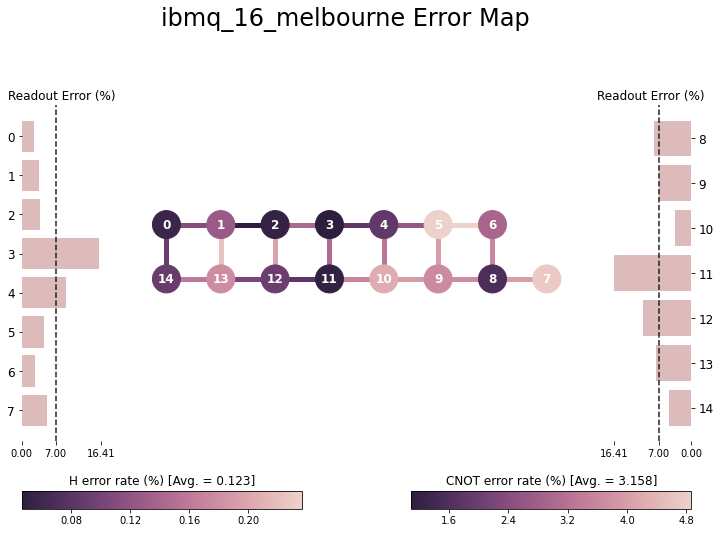

In [5]:
plot_error_map(real_backend)

An important aspect of the error map is showing connections between qubits. We can complicate our system a bit. For this, we create a simple circuit where we connect qubit Q0 with qubit Q2. As you can see in the diagram above, the qubits are not directly connected to each other. The task of the transpiler is to make our connection work well.

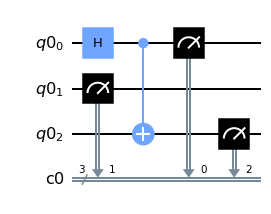

In [6]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr, cr)

circuit.draw(output='mpl')

Everything is quite legible on the generated circuit. We used the Hadamard gate on the first qubit, then the CNOT gate on qubits Q0 and Q2, and finally we set the measurement for all qubits. Below we will generate the actual appearance of such a circuit:

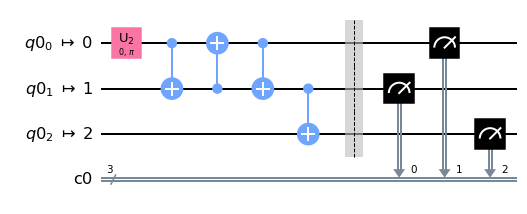

In [7]:
compiled_circuit = transpile(circuit, real_backend, optimization_level=0)
compiled_circuit.draw(output='mpl', idle_wires=False)

As you can see, the layout doesn't look so good. We used the transpile command to generate the actual circuit scheme. There are two things to note in the code above. The first is the `optimization_level` command, which defines how much our code should be optimized. The second is `idle_wires`, which just hides the rest of the machine's qubits, giving you a clean circuit. The Hadamard gate is marked with the symbol U2 because it is a native gate. Then a [SWAP gate](https://qiskit.org/textbook/ch-gates/more-circuit-identities.html#2.-Swapping-Qubits-) was used on the Q1 qubit, after which it was finally possible to get to the Q2 qubit. The measurements also changed, this time the value of the qubit Q1 is measured on the qubit Q0 and vice versa. Now let's optimize our circuit:

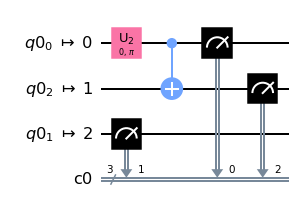

In [8]:
compiled_circuit = transpile(circuit, real_backend, optimization_level=3)
compiled_circuit.draw(output='mpl', idle_wires=False)

Everything looks better now. It is worth noting that qubits Q1 and Q2 have been swapped so that the existing connection between Q0 and Q1 can be used. We haven't done much work on these qubits, so the computer could swap them with itself without affecting the final result. The measurements also changed again. This time the value of Q1 is measured at Q2. Comparing to the original layout, we did not perform any operation on Q1 before measuring. Now, such an unused qubit is Q2. A brief description of the optimization levels is provided below:

* `optimization_level=0`: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does)

* `optimization_level=1`: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

* `optimization_level=2`: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

* `optimization_level=3`: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

For the above exercise, we used the so-called **Bell states**, which are specific quantum states of two qubits that represent the simplest (and maximal) examples of quantum entanglement. Now we will create a more complicated circuit, on which we will present how many gates we can reduce.

In [9]:
qr2 = QuantumRegister(14)
cr2 = ClassicalRegister(14)
circuit2 = QuantumCircuit(qr2, cr2)

circuit2.h(qr2[0])
circuit2.cx(qr2[0], qr2[6])
circuit2.cx(qr2[6], qr2[13])
circuit2.cx(qr2[13], qr2[7])
circuit2.cx(qr2[7], qr2[0])
circuit2.measure(qr2, cr2)

In [10]:
for level in range(4):
    compiled_circuit2 = transpile(circuit2, real_backend, optimization_level=level)
    print('---------- Level = ' + str(level) + '----------')
    print('gates = ', compiled_circuit2.count_ops())
    print('depth = ', compiled_circuit2.depth())

---------- Level = 0----------
gates =  OrderedDict([('cx', 46), ('measure', 14), ('u2', 1), ('barrier', 1)])
depth =  29
---------- Level = 1----------
gates =  OrderedDict([('cx', 37), ('measure', 14), ('u2', 1), ('barrier', 1)])
depth =  24
---------- Level = 2----------
gates =  OrderedDict([('measure', 14), ('cx', 4), ('u2', 1)])
depth =  6
---------- Level = 3----------
gates =  OrderedDict([('measure', 14), ('cx', 4), ('u2', 1)])
depth =  6


In the above code, we used the `while loop` to generate a list of gates and steps that we need to complete the circuit with four different optimization levels. In the above code, we used the `while loop` to generate a list of gates and steps that we need to complete the circuit with four different optimization levels. You can see the difference at the CNOT (cx) gates where their number dropped from 46 to only 4! The number of time steps (depth) has also changed. They define the number of steps needed to complete the circuit. Suppose we use Hadamard gates on all qubits. One step is all it takes because the qubits work simultaneously. However, if we then add a NOT gate, two steps will have to be performed.